In [22]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

In [23]:
# Requirement 1 - Implement a uniform scalar quantizer function
# Parameters:
#     in_val : vector with the original samples
#     n_bits : number of bits available to quantize one sample
#     xmax : max value in samples values
#     m : 0 -> mibrise, 1 -> midtread
# Output:
#     q_ind :  index of the chosen quantization level
def UniformQuantizer(in_val, n_bits, xmax, m):
    q_ind = np.zeros(len(in_val))

    # number of quantized levels 
    number_of_levels = 2**n_bits

    # delta is the width of each quantization level
    delta = 2 * xmax / number_of_levels

    xmin = xmax - (delta - ((1 - m) * (delta / 2)))

    i = 0
    for value in in_val:
        if(value < -xmin):
            value = -xmin
        error = (value + xmin) % delta
        q_ind[i] = (value + xmin) // delta
        if(error > delta/2):
            q_ind[i] = q_ind[i] + 1
        i = i + 1
    return q_ind
    


In [24]:
# Requirement 2- Implement a uniform scaler de-quantizer function with the header
# Parameters:
#     q_ind : vector with the quantized values indeces
#     n_bits : number of bits available to quantize one sample
#     xmax : max value in samples values
#     m : 0 -> mibrise, 1 -> midtread
# Output:
#     deq_value :  value of each index
def UniformDequantizer(q_ind,n_bits,xmax,m):
    number_of_levels = 2**n_bits
    delta = 2 * xmax / number_of_levels
    xmin = xmax - (delta - ((1 - m) * (delta/2)))
    deq_val = [(value * delta - xmin) for value in q_ind]
    return deq_val  

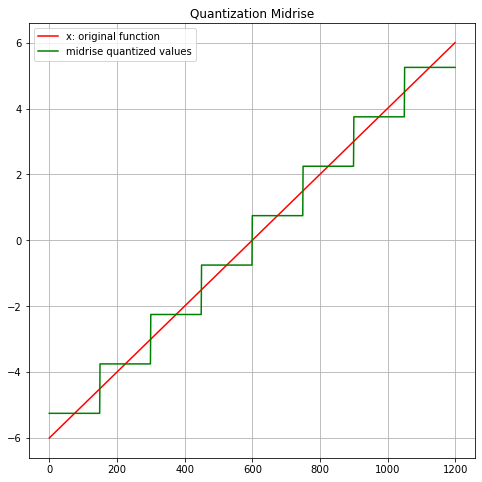

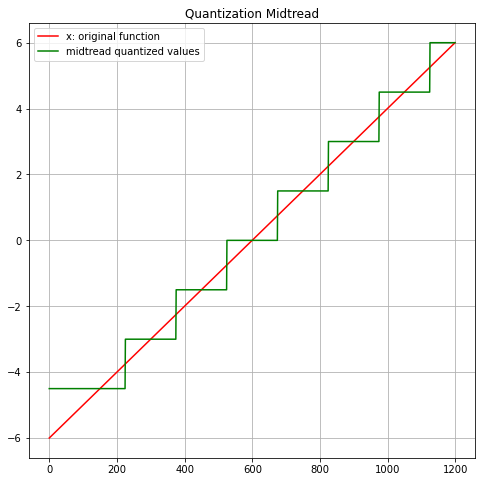

In [25]:
# Requirement 3 - Test the quantizer/dequantizer functions on a deterministic input

# 3.1- Midrise quantization: m = 0
x = np.linspace(-6, 6, 1200)
midrise_quantization = UniformQuantizer(x, 3, 6, 0)
midrise_dequantization = UniformDequantizer(midrise_quantization, 3, 6, 0)

#ploting
plt.figure(figsize=(8,8))
plt.plot(range(0, len(x)), x, label = "x: original function", color = 'red')
plt.plot(range(0, len(x)), midrise_dequantization, label = "midrise quantized values", color = 'green')

plt.title('Quantization Midrise')

plt.legend()
plt.grid()
plt.show()

# 3.2- Midtread quantization: m = 1
midrise_quantization = UniformQuantizer(x, 3, 6, 1)
midrise_dequantization = UniformDequantizer(midrise_quantization, 3, 6, 1)

#ploting
plt.figure(figsize=(8,8))
plt.plot(range(0, len(x)), x, label = "x: original function", color = 'red')
plt.plot(range(0, len(x)), midrise_dequantization, label = "midtread quantized values", color = 'green')

plt.title('Quantization Midtread')

plt.legend()
plt.grid()
plt.show()

In [26]:
# GENERAL FUNCTIONS

# Calcutales experimental and theoretical signal to noise ratio of of the signal 
# Parameters:
#   samples : vector of function samples 
#   quantized_levels : vector of quantized samples
#   n_bits : number of bits to decode the level
#   max_value : max value in samples
# Output:
#   theoretical_snr : calculate the SNR with the equation
#   simulation_snr : calculate the SNR from the real values
def SNR(samples, quantized_levels, n_bits, xmax, 𝝁=0):
    quantization_error = samples - quantized_levels
    signal_power = np.mean(samples**2)
    error_power = np.mean(quantization_error**2)
    
    theoretical_snr = ((3* (2**n_bits)) / ((np.log(1+𝝁))**2)) if 𝝁 > 0 else ((3 * (2**n_bits)**2 * signal_power) / xmax**2)
    simulation_snr = signal_power/error_power
    return theoretical_snr, simulation_snr

# μ-Law Quantizer
# Expands signal
def ExpandSignal(samples, 𝝁):
    return np.sign(samples) * (np.log(1 + 𝝁 * np.absolute(samples)) / np.log(1 + 𝝁)) if 𝝁 > 0 else np.copy(samples)
     
# μ-Law Quantizer
# Compresses signal
def CompressSignal(samples, 𝝁):
    if(𝝁 > 0):
        y = ((1 + 𝝁) ** np.absolute(samples) - 1) / 𝝁
        return y * (np.sign(samples))
    else:
        return np.copy(samples)

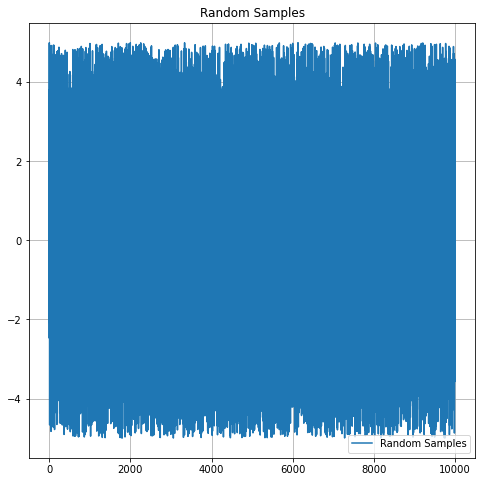

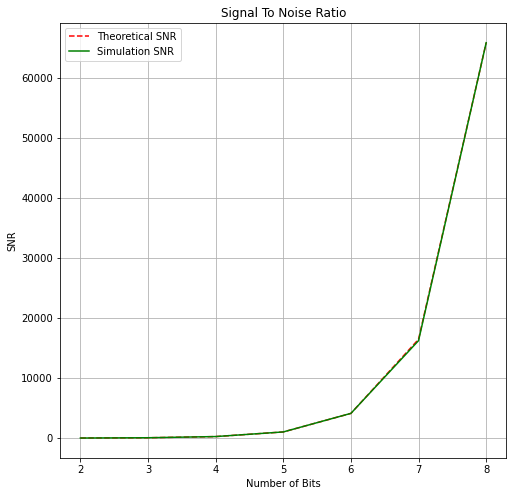

In [27]:
# Requirement 4 - Now test your input on a random input signal as follows:
random_samples = np.random.uniform(low=-5, high=5, size=10000)
plt.figure(figsize=(8,8))
plt.plot(range(0, len(random_samples)), random_samples, label = "Random Samples")

plt.title('Random Samples')

plt.legend()
plt.grid()
plt.show()

theoretical_snr = []
simulation_snr = []

# calculate for number of bits 2:1:8
for i in range(2, 9):
    # calculate quntization level for each samples (midrise)
    quantized = UniformQuantizer(random_samples, i, 5, 0)
    dequantized = UniformDequantizer(quantized, i, 5, 0)
    snr_t, snr_s = SNR(random_samples, dequantized, i, 5)
    theoretical_snr.append(snr_t)
    simulation_snr.append(snr_s)

# convert to in db
# theoretical_snr = 10*np.log10(theoretical_snr)
# simulation_snr = 10*np.log10(simulation_snr)

plt.figure(figsize=(8,8))
plt.plot(range(2,9), theoretical_snr, '--', label = "Theoretical SNR", color = 'red')
plt.plot(range(2,9), simulation_snr , label = "Simulation SNR", color = 'green')

plt.xlabel('Number of Bits')
plt.ylabel('SNR')
plt.title('Signal To Noise Ratio')

plt.legend()
plt.grid()
plt.show()


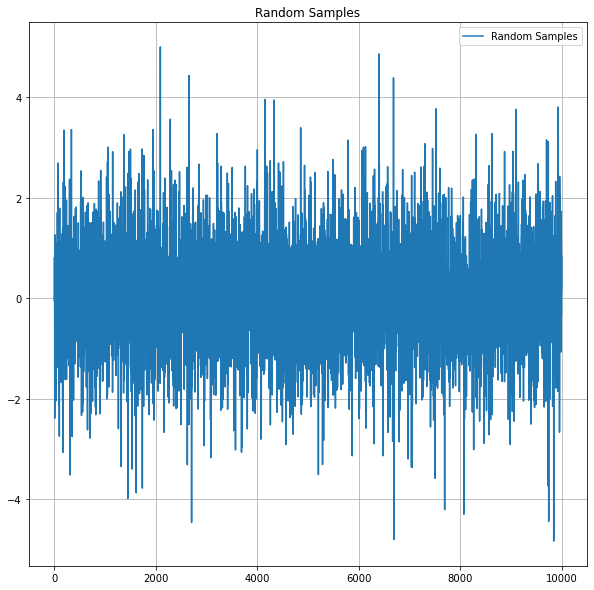

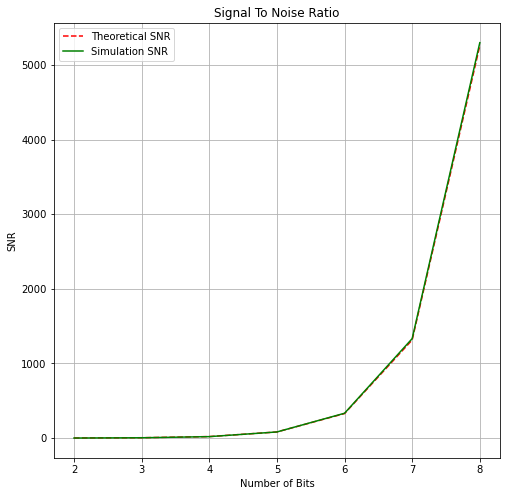

In [28]:
# Requirement 5 - Test the uniform quantizer on a non-uniform random input 
random_samples = np.random.exponential(1, 10000)
random_samples = (random_samples / np.amax(random_samples)) * (5 * np.random.choice([-1, 1], size=(10000), p=[0.5, 0.5]))

plt.figure(figsize=(10,10))
plt.plot(range(0, len(random_samples)), random_samples, label = "Random Samples")

plt.title('Random Samples')

plt.legend()
plt.grid()
plt.show()

theoretical_snr = []
simulation_snr = []

# calculate for number of bits 2:1:8
for i in range(2, 9):
    # calculate quntization level for each samples (midrise)
    quantized = UniformQuantizer(random_samples, i, 5, 0)
    dequantized = UniformDequantizer(quantized, i, 5, 0)
    snr_t, snr_s = SNR(random_samples, dequantized, i, 5)
    theoretical_snr.append(snr_t)
    simulation_snr.append(snr_s)

# convert to in db
# theoretical_snr = 10*np.log10(theoretical_snr)
# simulation_snr = 10*np.log10(simulation_snr)

plt.figure(figsize=(8,8))
plt.plot(range(2,9), theoretical_snr, '--', label = "Theoretical SNR", color = 'red')
plt.plot(range(2,9), simulation_snr , label = "Simulation SNR", color = 'green')

plt.xlabel('Number of Bits')
plt.ylabel('SNR')
plt.title('Signal To Noise Ratio')

plt.legend()
plt.grid()
plt.show()

c:\Users\yazmi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 120641 (\N{MATHEMATICAL BOLD ITALIC SMALL MU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


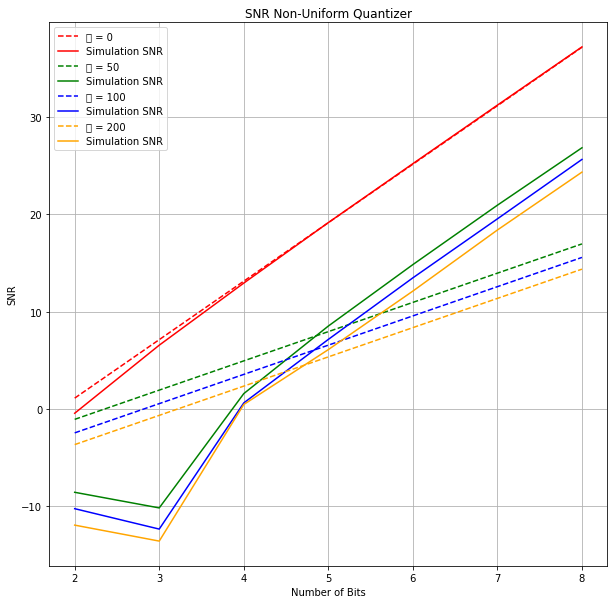

In [29]:
# Requirement 6 - Quantize the the non-uniform signal using a non-uniform 𝝁 law quantizer
colors = ['red', 'green', 'blue', 'orange']
colors_counter = 0

plt.figure(figsize=(10,10))

for 𝝁 in [0, 50, 100, 200]:
    expanded_signal = ExpandSignal(random_samples, 𝝁)
    theoretical_snr = []
    simulation_snr = []

    # calculate for number of bits 2:1:8
    for j in range(2, 9):
        # calculate quntization level for each samples (midrise)
        expanded_quantized = UniformQuantizer(expanded_signal, j, 5, 0)
        expanded_dequantized = UniformDequantizer(expanded_quantized, j, 5, 0)
        compressed_signal = CompressSignal(expanded_dequantized, 𝝁)
        snr_t, snr_s = SNR(random_samples, compressed_signal, j, 5, 𝝁)
        theoretical_snr.append(snr_t)
        simulation_snr.append(snr_s)

    # convert to in db
    theoretical_snr = 10*np.log10(theoretical_snr)
    simulation_snr = 10*np.log10(simulation_snr)

    #ploting
    plt.plot(range(2,9), theoretical_snr, '--', label = "𝝁 = " + str(𝝁), color = colors[colors_counter])
    plt.plot(range(2,9), simulation_snr , label = "Simulation SNR", color = colors[colors_counter])
    colors_counter += 1

plt.xlabel('Number of Bits')
plt.ylabel('SNR')
plt.title('SNR Non-Uniform Quantizer')

plt.legend()
plt.grid()
plt.show()
